In [ ]:
#Here we install R, the bridge package rpy2 between the two languages and the R package Salso. Need to install each time since the Colab runtime is temporary
!apt-get install -y r-base
!pip install rpy2
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh -s -- --no-modify-path -y
!Rscript -e "install.packages('salso', repos='http://cran.r-project.org')"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
info: downloading installer
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: latest update on 2025-12-11, rust version 1.92.0 (ded5c06cf 2025-12-08)
info: downloading component 'cargo'
info: downloading component 'clippy'
info: downloading component 'rust-docs'
info: downloading component 'rust-std'
info: downloading component 'rustc'
info: downloading component 'rustfmt'
info: installing component 'cargo'
info: installing component 'clippy'
info: installing component 'rust-docs'
 20.5 MiB /  20.5 MiB (100 %)   2.2 MiB/s in  7s
info: installing component 'rust-std'
 28.0 MiB /  28.0 MiB (100 %)  13.8 MiB/s in  2s
info: installing component 'rustc'
 74.3 MiB /  74.3 M

In [ ]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import nct
from tqdm import tqdm
import time
import random
import copy
plt.style.use('default')
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
salso = importr("salso") #import salso package in R
#To convert Python vector/matrices into R ones
from rpy2.robjects import r, IntVector
from rpy2.robjects.vectors import IntMatrix
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Thesis/Plots/mean only')

In [ ]:
np.random.seed(1)

# Simulation

### Generating the mixture

Here we first generate a mixture distribution on normals and then we sample from it. The goal is then to approximate using the sample the real distribution. The following are the parameters of the distributions.


Mixture of $T = 3$ normal distributions. We have: $\mathcal{N}(0, 1)$, $\mathcal{N}(-15, 1)$, $\mathcal{N}(18, 1)$ with weights $0.5, 0.25, 0.25$ respectively.

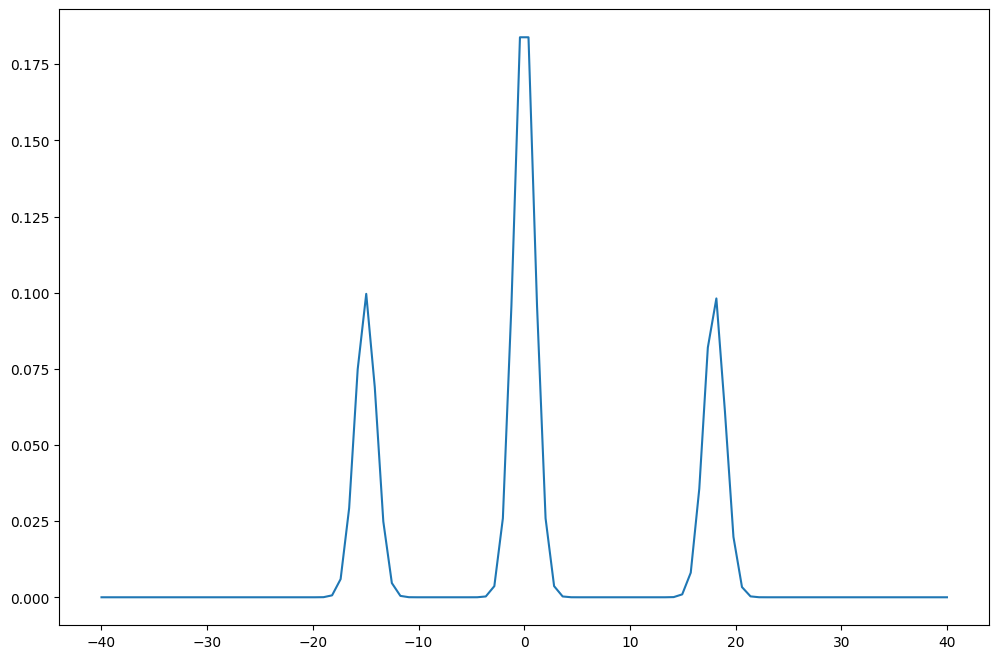

In [ ]:
#Generating true distributions (for plotting the true one only)
fig, ax = plt.subplots(figsize = (12, 8))
n = 100
support = np.linspace(-40, 40, n)
weights = np.array([0.5, 0.25, 0.25])
dens1 = ss.norm.pdf(support, 0, 1)
dens2 = ss.norm.pdf(support, -15, 1)
dens3 = ss.norm.pdf(support, 18, 1)
densities = np.array([dens1, dens2, dens3])
mixture = np.dot(weights, densities)
ax.plot(support, mixture)
plt.savefig('real_pdf.pdf')

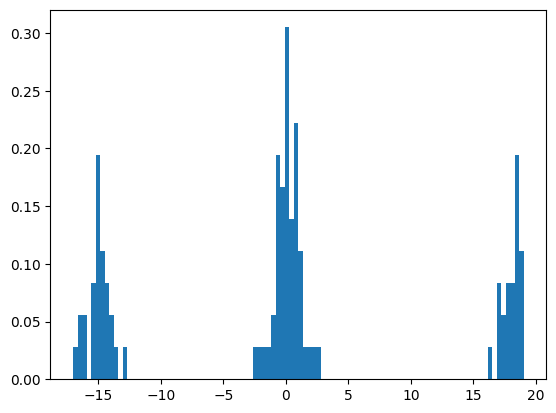

In [ ]:
#Generating a random sample from the above mixture
un_val = np.random.uniform(0, 1, n)
sample = np.empty(n)
counter = [0, 0, 0]
colors = []
for i in range(n):
    if un_val[i] < weights[0]:
        sample[i] = np.random.normal(0, 1)
        counter[0] += 1
        colors.append('blue')
    elif un_val[i] < (weights[0] + weights[1]):
        sample[i] = np.random.normal(-15, 1)
        counter[1] += 1
        colors.append('orange')
    else:
        sample[i] = np.random.normal(18, 1)
        counter[2] += 1
        colors.append('green')
plt.hist(sample, bins = 100, density = True);

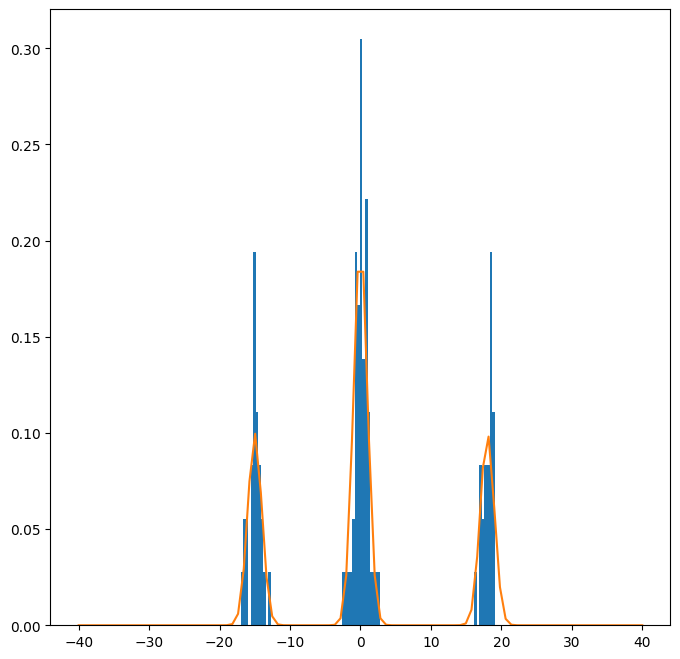

In [ ]:
#Combining plots
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
plt.hist(sample, bins = 100, density = True)
plt.plot(support, mixture)
plt.show()

### Functions

Below we group all the function used in the following cells: there are some used in the Gibbs sampler and others used for sampling/estimating the predictive distribution.

In [ ]:
def normal_pdf(x, mu, sigmaq): #pass variance, not sd
    return np.exp(-(x - mu)**2/(2*sigmaq))/(math.sqrt(2*math.pi*sigmaq))

In [ ]:
def cluster_prob(element_index, gamma):
    element = sample[element_index]
    k = len(partition)
    probs_unnorm = [0 for i in range(k)]
    for i in range(k):
        #Gathering needed quantities
        n_i = len(partition[i])
        cluster_data_sum = sum(sample[partition[i]])
        #Computing the probabilities (unnormalized) for each cluster
        probs_unnorm[i] = (1 + n_i)*(n + gamma - k - 1)*normal_pdf(element, (cluster_data_sum + mu0/sigmaq)/(1/sigmaq + n_i), (1 + n_i + 1/sigmaq)/(n_i + 1/sigmaq))
    #Computing the probability (unnormalized) for a new cluster
    probs_unnorm.append((k**2 - gamma*k)*normal_pdf(element, mu0, sigmaq + 1))
    #Computing the normalization constant
    Z = sum(probs_unnorm)
    probs_unnorm = np.array(probs_unnorm)
    probs_norm = probs_unnorm/Z
    return probs_norm

In [ ]:
def cluster_assign(probs):
    U = np.random.uniform(0, 1)
    cum = probs[0]
    i = 0
    while U > cum:
        i += 1
        cum += probs[i]
    return i

In [ ]:
def posterior_predictive_pdf(support, gamma):
    S = len(partitions)
    pred_sample = []
    for s in range(S):
        k = len(partitions[s])
        part = partitions[s]
        probs_part = []
        weights_unnorm = []
        for i in range(k):
            n_i = len(part[i])
            cluster_data_sum = sum(sample[part[i]])
            probs_part.append(ss.norm.pdf(support, (cluster_data_sum + mu0/sigmaq)/(1/sigmaq + n_i), math.sqrt((1 + n_i + 1/sigmaq)/(n_i + 1/sigmaq))))
            weights_unnorm.append((1 + n_i)*(n + gamma - k))
        probs_part.append(ss.norm.pdf(support, mu0, math.sqrt(sigmaq + 1)))
        weights_unnorm.append((k**2 - gamma*k))
        weights_unnorm = np.asarray(weights_unnorm)
        Z = sum(weights_unnorm)
        weights_norm = weights_unnorm/Z
        pred_sample.append(np.dot(weights_norm, probs_part))
    final_eval = np.sum(pred_sample, axis = 0)/S
    return final_eval, pred_sample

### Gibbs Sampler

In the following cell, there are some parameters to set up; these are:
* $T$, which is the number of scans to be performed by the sampler;
* $\gamma$, that is the parameter of the Gnedin process: It must be that $0 < \gamma < 1$;
* $\mu_0$, the mean of the normal prior on $\mu$;
* $\sigma_0^2$, the variance of the normal prior on $\mu$.

In [ ]:
T = 10000
gamma = 0.5
mu0 = np.mean(sample)
sigmaq = np.var(sample)
partition = [[j for j in range(n)]]

Run the following cell to start the algorithm

In [ ]:
start = time.time()
probs = []
partitions = []
cluster_growth = [1]
lookup = {i : 0 for i in range(n)}
for t in tqdm(range(T)):
    for j in range(n):
        #Remove element j
        index = lookup.get(j)
        partition[index].remove(j)
        if not partition[index]:
            del partition[index]
            #Adjust lookup table by scaling the indexes
            for l in range(n):
                if lookup[l] > index:
                    lookup[l] = lookup[l] - 1
            #Should be faster but it's slower
            '''lookup = {key : value - 1 if lookup[key] > index else value for key, value in lookup.items()}'''
        #Compute probabilities of assignment for element j
        probs.append(cluster_prob(j, gamma))
        cluster_index = cluster_assign(probs[-1])
        if cluster_index == (len(probs[-1]) - 1): #i.e., if the index is referring to the probab. of getting a new cluster
            partition.append([j])
            #print('new cluster!')
        else:
            partition[cluster_index].append(j)
            #print('j-th element assigned to cluster', cluster_index)
        lookup[j] = cluster_index
    partitions.append(copy.deepcopy(partition))
    cluster_growth.append(len(partition))
print('Done!', round(time.time() - start, 3), 's')

100%|██████████| 10000/10000 [00:39<00:00, 250.02it/s]

Done! 40.006 s


### Diagnostic plots

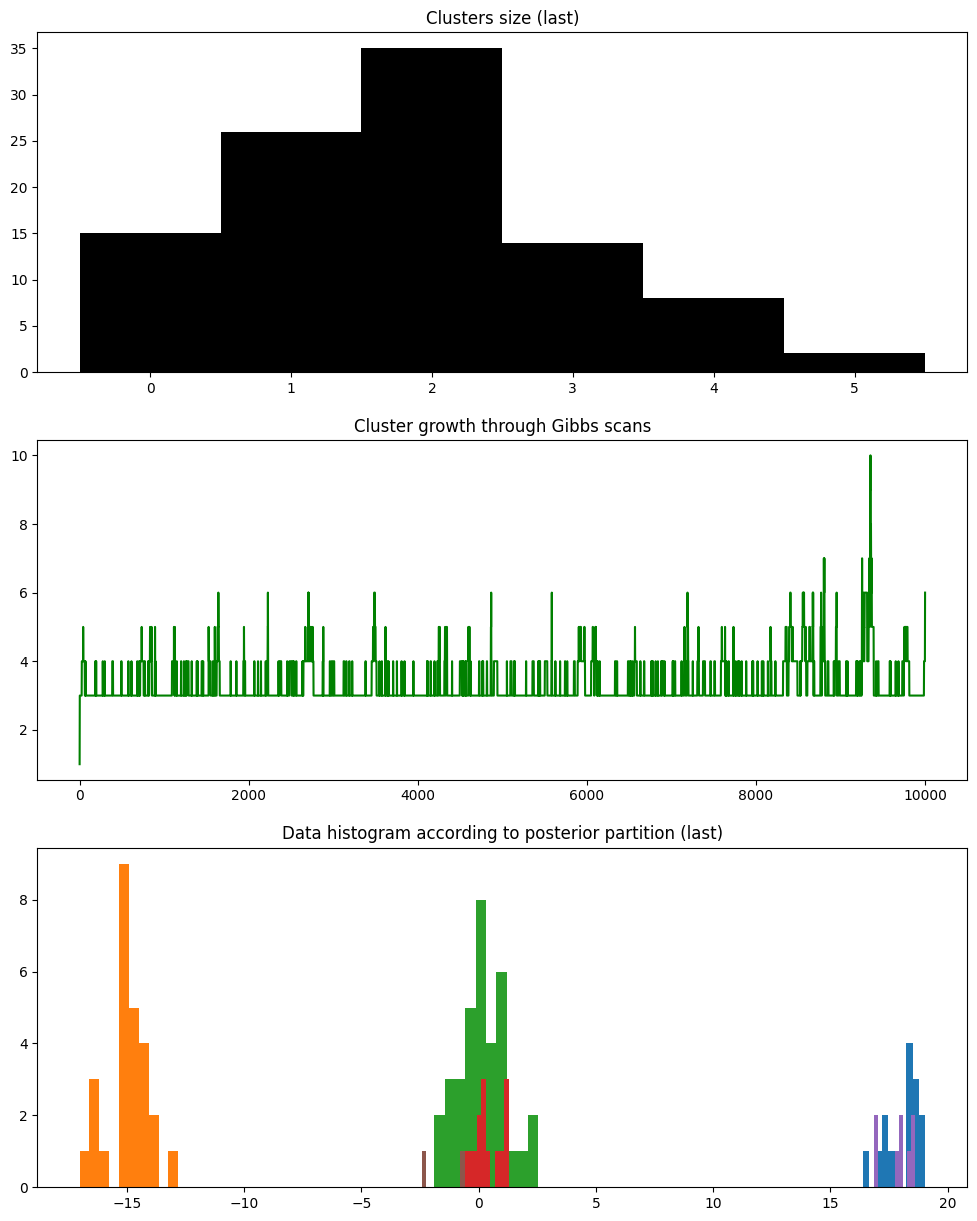

In [ ]:
#The first and last plot are generated according to the partition estimated by the last Gibbs iteration. Below you can find the ones generated with the optimal partition, which are more significative.
fig = plt.figure(figsize = (12, 15))

#Plot 1
cluster_dim = [len(partition[i]) for i in range(len(partition))]
ax1 = fig.add_subplot(311)
plt.bar(x = range(len(partition)), height = cluster_dim, width = 1, color = 'k')
ax1.set_title('Clusters size (last)')

#Plot 2
ax2 = fig.add_subplot(312)
plt.plot(cluster_growth, 'g')
ax2.set_title('Cluster growth through Gibbs scans')

#Plot 3
ax3 = fig.add_subplot(313)
for i in range(len(partition)):
    plt.hist(sample[partition[i]])
ax3.set_title('Data histogram according to posterior partition (last)')

### Density Estimation

Here we estimate the true data-generating distribution using MCMC runs of the algorithm above. We discard the first $5000$ iterations as burn-in phase.

In [ ]:
#Evaluating the predictive distribution on support
partitions = partitions[5000:] #discard first 5000 partitions (burn-in)
post_dens, pred_sample = posterior_predictive_pdf(support, gamma)

In [ ]:
#Generating colors and weights for each cluster (for plotting purposes)
colors_post = np.array(['']*n, dtype = 'object')
importance = np.array([0]*n)
for i in range(len(partition)):
    importance[partition[i]] = len(partition[i])
    colors_post[partition[i]] = '#{:06x}'.format(random.randint(0, 0xFFFFFF)) #generate random hex color code

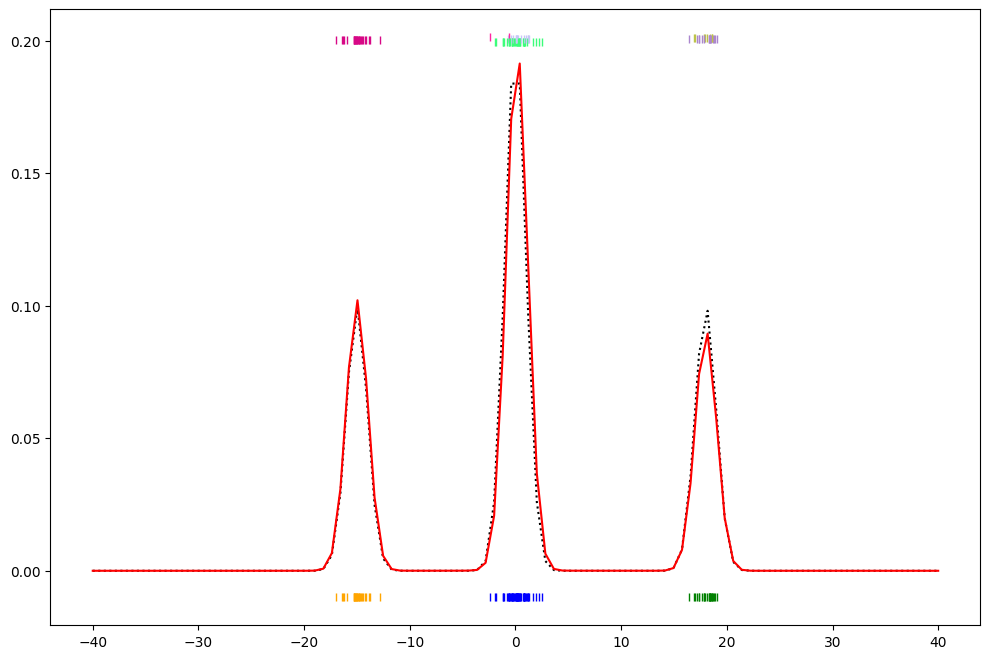

In [ ]:
#The rugs on the top of the density estimation plot are colored according to the partition estimated by the last Gibbs iteration. Below you can find the plot with rugs colored according to the optimal partition, which is more significative.
#Plotting
maxx = max(max(mixture), max(post_dens))
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(support, mixture, color = 'k', linestyle = 'dotted')
#plt.plot(support, dens1*.5, linestyle = 'dotted', color = 'blue')
#plt.plot(support, dens2*.25, linestyle = 'dotted', color = 'orange')
#plt.plot(support, dens3*.25, linestyle = 'dotted', color = 'green')
plt.plot(support, post_dens, color = 'r')
for i in range(n):
    plt.plot(sample[i], -0.01, '|', color = colors[i])
    plt.plot(sample[i], maxx + 0.01 - (importance[i]*0.00005), '|', color = colors_post[i])
#ax.set_title('Mixture points allocations according to true density (bottom) and posterior (top, last)')
#plt.savefig('post_estim'+f'{n}'+'.pdf')

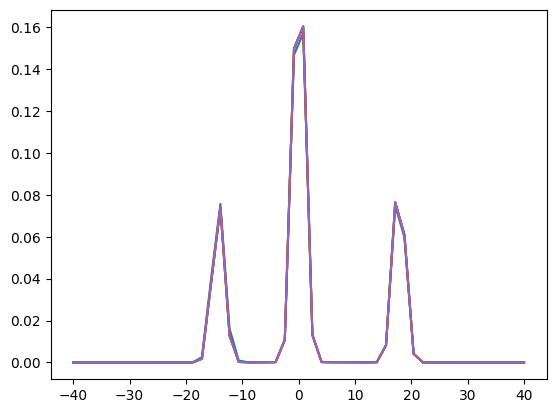

In [ ]:
#We pick at random some of the distributions averaged to obtain the above and we plot them.
for i in range(5):
    plt.plot(support, pred_sample[np.random.randint(0, 5000)])

### Salso

In [ ]:
#We convert the partitions object into a matrix with the same meaning
partitions_mat = np.zeros((T - 5000, n), dtype=np.int32)
for s in range(len(partitions)):
  numb_cl = len(partitions[s])
  for i in range(numb_cl):
    indexes = partitions[s][i]
    partitions_mat[s, indexes] = i+1

In [ ]:
#Activate conversion
numpy2ri.activate()
#Send to R
r_mat = robjects.r.matrix(partitions_mat, nrow=partitions_mat.shape[0], ncol=partitions_mat.shape[1])
print(partitions_mat)

[[3 1 3 ... 1 3 1]
 [3 1 3 ... 1 3 1]
 [3 1 3 ... 1 3 1]
 ...
 [3 2 3 ... 2 3 2]
 [3 2 3 ... 2 6 2]
 [3 2 3 ... 2 3 2]]


In [ ]:
#Run SALSO
results = salso.salso(r_mat)
print('Cluster assignment:', list(results))
opt_part_r = np.array(list(results))

Cluster assignment: [1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 1, 3, 1, 1, 3, 2, 2, 1, 2, 3, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 3, 2, 3, 1, 1, 3, 1, 1, 3, 1, 3, 2, 3, 2, 3, 1, 1, 3, 1, 3, 2, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, 2]


In [ ]:
#We convert the salso output into our partition format
opt_part = []
cl_number = np.unique(opt_part_r)
for i in range(len(cl_number)):
  opt_part.append(np.where(opt_part_r == cl_number[i])[0].tolist())

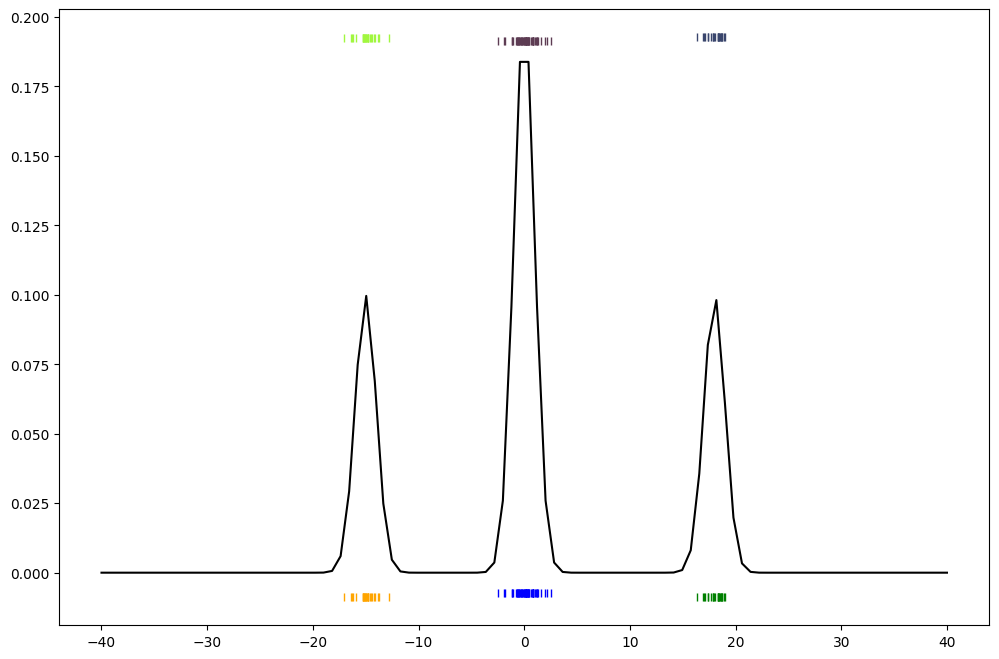

In [ ]:
#Similarly as before, we now plot the optimal partition from salso against the real sample from the mixture
#Determining colors and importance for optimal partition
col = ['#{:06x}'.format(random.randint(0, 0xFFFFFF)) for i in range(len(cl_number))]
opt_color = np.array(['']*n, dtype = 'object')
opt_importance = np.array([0]*n)
for i in range(len(cl_number)):
  opt_color[opt_part[i]] = col[i]
  opt_importance[opt_part[i]] = len(opt_part[i])

#Determining importance for original sample from the mixture
colors = np.array(colors) #otherwise we could have some problems with np.where
un_col = np.unique(colors)
importance = np.array([0]*n)
for i in range(len(un_col)):
  importance[np.where(colors == un_col[i])[0].tolist()] = counter[i]

#Plotting
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(support, mixture, color = 'black')
for i in range(n):
  ax.plot(sample[i], min(mixture) - 0.01 + (importance[i]*0.00005), '|', color = colors[i])
  ax.plot(sample[i], max(mixture) + 0.01 - (opt_importance[i]*0.00005), '|', color = opt_color[i])

In [ ]:
#Computing posterior similarity matrix
psm = salso.psm(r_mat)
#With this we reorder the rows and columns of the psm by the optimal cluster found by salso
order = np.argsort(opt_part_r)

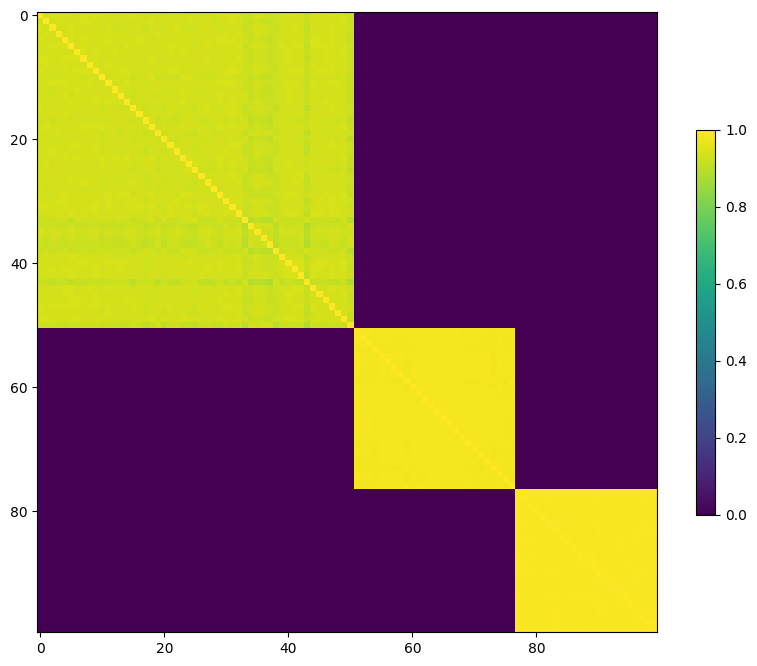

In [ ]:
#We now plot the reordered psm as an image using a color map.
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(111)
plot = ax1.imshow(psm[order][:, order], cmap = 'viridis') #we reorder rows and columns according to the 'best' partition from salso
plt.colorbar(plot, shrink = .5)
#ax1.set_axis_off()
plt.savefig('psm.pdf')

In [ ]:
#Get other metrics
binder_val   = salso.binder(results, r_mat)
vi_val       = salso.VI(results, r_mat)

print("Binder loss:", binder_val[0])
print("VI:", vi_val[0])

Binder loss: 0.0
VI: 0.0


### Density Estimation (Rug plots using optimal partition)

Above we plotted the density estimation using for the rugs the last partition constructed by the Gibbs scan; now we plot the same but each time we use the optimal partition found using Salso package

In [ ]:
#Generating colors and weights for each cluster (for plotting purposes)
colors_post = np.array(['']*n, dtype = 'object')
importance = np.array([0]*n)
for i in range(len(opt_part)):
    importance[opt_part[i]] = len(opt_part[i])
    colors_post[opt_part[i]] = '#{:06x}'.format(random.randint(0, 0xFFFFFF)) #generate random hex color code

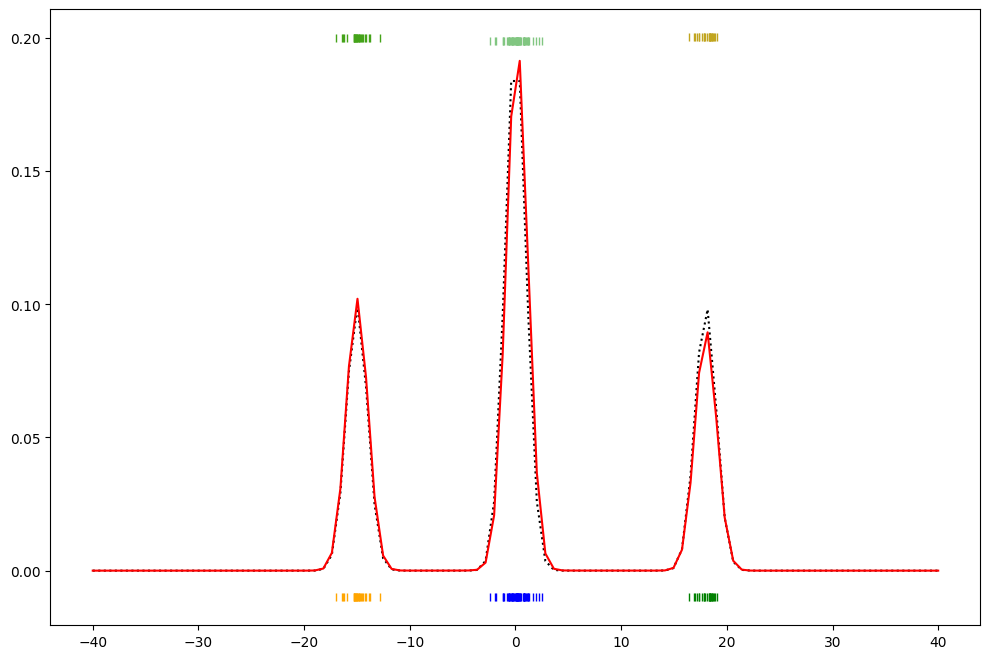

In [ ]:
#Plotting
maxx = max(max(mixture), max(post_dens))
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(support, mixture, color = 'k', linestyle = 'dotted')
#plt.plot(support, dens1*.5, linestyle = 'dotted', color = 'blue')
#plt.plot(support, dens2*.25, linestyle = 'dotted', color = 'orange')
#plt.plot(support, dens3*.25, linestyle = 'dotted', color = 'green')
plt.plot(support, post_dens, color = 'r')
for i in range(n):
    plt.plot(sample[i], -0.01, '|', color = colors[i])
    plt.plot(sample[i], maxx + 0.01 - (importance[i]*0.00005), '|', color = colors_post[i])
#ax.set_title('Mixture points allocations according to true density (bottom) and posterior (top, last)')
plt.savefig('post_estim'+f'{n}'+'.pdf')

### Other plots using optimal partition

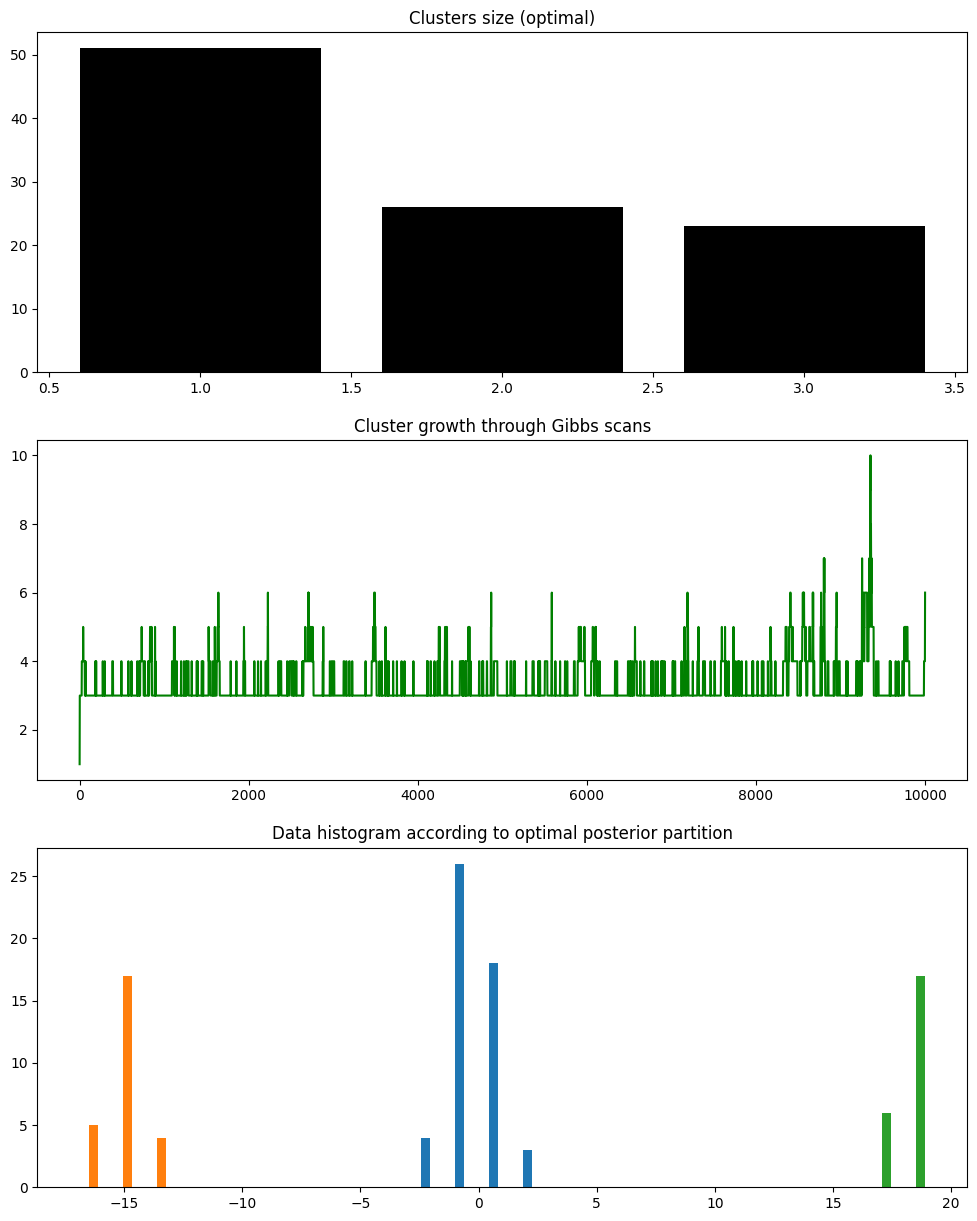

In [ ]:
#We now do the same plot as the first showed one but using the optimal partition, not the last iteration
fig, axes = plt.subplots(3, 1, figsize = (12, 15))
cl, counts = np.unique(opt_part_r, return_counts = True)
axes[0].bar(cl, counts, color = 'k')
axes[0].set_title('Clusters size (optimal)')

axes[1].plot(cluster_growth, 'g')
axes[1].set_title('Cluster growth through Gibbs scans')

masked_samp = []
for i in range(len(opt_part)):
  masked_samp.append(sample[opt_part[i]])
axes[2].hist(masked_samp, bins = 25)
axes[2].set_title('Data histogram according to optimal posterior partition')

plt.savefig('diagnostic.pdf')